# Steam Game Data Analysis

I came across this post in the r/datasets subreddit where the user u/Rokanov has posted a data set that he had downloaded from the Steam and SteamSpy APIs. It includes release data, developers, publisher, genres, positive/negative ratings, average/medium, playtime, number of owners, price, descriptions media data (e.g. screenshots), system requirements, and support info (company url and email).

You can find the dataset under the user's Kaggle page here:
<br>
[Steam Store Games](https://www.kaggle.com/nikdavis/steam-store-games)

I am avid gamer and Steam is the main platform that I play on and I have always been curious to explore a dataset on Steam. Thanks to u/Rokanov aka Nik Davis, he has compiled an impressive data set that I can't wait to explore deeper.

In [1]:
#imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [2]:
#reading in the data
steam_data = pd.read_csv('steam.csv')

In [3]:
#top 5 rows of data
steam_data.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


## Data Cleaning

The data set comes with several different files, but I have decided to focusing on the "steam.csv" file.

The steam data set already comes in a cleaned state so there is not much for me to do. However, there is some additional cleaning that I would like to do that will be helpful in our analysis.

- Break down the release dates into seperate columns by year, month, and day
- Filter out non-english games
- Break down the categories/genres into seperate binary columns
    - Decided to not use the steamspy_tags because those there are redudent information that we already can get from the categories/genres column
- Compute the rating for each game. Will be using the same rating equation as Steam. [Steam's Rating Algorithm](https://steamdb.info/blog/steamdb-rating/)
- Remove platform column
- Remove required_age column
- Remove achievements column

### Splting the Release Date column into seperate columns

In [4]:
#create copy of dataframe
cleaned_date = steam_data.copy()

In [5]:
#splitting release data column
release_date_split = cleaned_date['release_date'].str.split('-', expand = True)

In [6]:
#first 5 results of splitted column
release_date_split.head()

,0,1,2
0,2000,11,01
1,1999,04,01
2,2003,05,01
3,2001,06,01
4,1999,11,01


In [7]:
#renaming the new columns
cleaned_date['year'] = release_date_split[0]
cleaned_date['month'] = release_date_split[1]
cleaned_date['day'] = release_date_split[2]

In [8]:
#first 5 results of the dataframe
cleaned_date.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,year,month,day
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,124534,3339,17612,317,10000000-20000000,7.19,2000,11,01
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,3318,633,277,62,5000000-10000000,3.99,1999,04,01
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,...,0,3416,398,187,34,5000000-10000000,3.99,2003,05,01
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,1273,267,258,184,5000000-10000000,3.99,2001,06,01
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,...,0,5250,288,624,415,5000000-10000000,3.99,1999,11,01


### Filter out non-english data

In [9]:
#create copy of dataframe
english_data = cleaned_date.copy()

In [10]:
#value count of english & non-english data
english_data['english'].value_counts()

1    26564
0      511
Name: english, dtype: int64

In [11]:
#filter out non-english data
english_data = english_data[english_data['english'] == 1]

In [12]:
#row and column count of new dataframe
english_data.shape

(26564, 21)

### Split the Genres Column into Seperate Binary Columns

In [13]:
#create copy of dataframe
cleaned_genres = english_data.copy()

In [14]:
#getting dummy variables of genres
seperated_genres = cleaned_genres['genres'].str.get_dummies(sep = ';')

In [15]:
seperated_genres.columns

Index(['Accounting', 'Action', 'Adventure', 'Animation & Modeling',
       'Audio Production', 'Casual', 'Design & Illustration', 'Documentary',
       'Early Access', 'Education', 'Free to Play', 'Game Development', 'Gore',
       'Indie', 'Massively Multiplayer', 'Nudity', 'Photo Editing', 'RPG',
       'Racing', 'Sexual Content', 'Simulation', 'Software Training', 'Sports',
       'Strategy', 'Tutorial', 'Utilities', 'Video Production', 'Violent',
       'Web Publishing'],
      dtype='object')

In [16]:
#concating dataframe with dummy variables
cleaned_genres = pd.concat([cleaned_genres, seperated_genres], axis = 1)

In [17]:
#Columns of dataframe
cleaned_genres.columns

Index(['appid', 'name', 'release_date', 'english', 'developer', 'publisher',
       'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags',
       'achievements', 'positive_ratings', 'negative_ratings',
       'average_playtime', 'median_playtime', 'owners', 'price', 'year',
       'month', 'day', 'Accounting', 'Action', 'Adventure',
       'Animation & Modeling', 'Audio Production', 'Casual',
       'Design & Illustration', 'Documentary', 'Early Access', 'Education',
       'Free to Play', 'Game Development', 'Gore', 'Indie',
       'Massively Multiplayer', 'Nudity', 'Photo Editing', 'RPG', 'Racing',
       'Sexual Content', 'Simulation', 'Software Training', 'Sports',
       'Strategy', 'Tutorial', 'Utilities', 'Video Production', 'Violent',
       'Web Publishing'],
      dtype='object')

### Clean the Owners Column and Split into Seperate Binary Columns

In [18]:
#create copy of dataframe
cleaned_owners = cleaned_genres.copy()

In [19]:
#value count of owners column
cleaned_owners['owners'].value_counts()

0-20000                18166
20000-50000             3016
50000-100000            1676
100000-200000           1373
200000-500000           1268
500000-1000000           513
1000000-2000000          287
2000000-5000000          192
5000000-10000000          46
10000000-20000000         21
20000000-50000000          3
50000000-100000000         2
100000000-200000000        1
Name: owners, dtype: int64

In [20]:
#variable of 10 million or more values
ten_million_plus = ['10000000-20000000', '20000000-50000000', '50000000-100000000', '100000000-200000000']

#cleaning values to be more readable 
cleaned_owners['owners'] = cleaned_owners['owners'].replace(ten_million_plus, '10m+')

In [21]:
#variable of uncleaned values
uncleaned_values = ['0-20000', 
                    '20000-50000',
                    '50000-100000',
                    '100000-200000', 
                    '200000-500000', 
                    '500000-1000000', 
                    '1000000-2000000', 
                    '2000000-5000000', 
                    '5000000-10000000']

#variable of cleaned values
cleaned_values = ['0-20k', 
                  '20k-50k', 
                  '50k-100k', 
                  '100k-200k', 
                  '200k-500k', 
                  '500k-1m', 
                  '1m-2m', 
                  '2m-5m', 
                  '5m-10m']

#replacing uncleaned values with cleaned values
cleaned_owners['owners'] = cleaned_owners['owners'].replace(uncleaned_values, cleaned_values)

In [22]:
#value count of cleaned values
cleaned_owners['owners'].value_counts()

0-20k        18166
20k-50k       3016
50k-100k      1676
100k-200k     1373
200k-500k     1268
500k-1m        513
1m-2m          287
2m-5m          192
5m-10m          46
10m+            27
Name: owners, dtype: int64

In [23]:
#getting dummy variables of owners
seperated_owners = cleaned_owners['owners'].str.get_dummies()

In [24]:
#values to sort chart by
number_of_owners = ['0-20k', 
                    '20k-50k', 
                    '50k-100k', 
                    '100k-200k', 
                    '200k-500k', 
                    '500k-1m', 
                    '1m-2m', 
                    '2m-5m', 
                    '5m-10m',
                   '10m+']

In [25]:
#sorting dummy variable dataframe
seperated_owners = seperated_owners[number_of_owners]

In [26]:
cleaned_owners = pd.concat([cleaned_owners, seperated_owners], axis = 1)

In [27]:
list(cleaned_owners)

['appid',
 'name',
 'release_date',
 'english',
 'developer',
 'publisher',
 'platforms',
 'required_age',
 'categories',
 'genres',
 'steamspy_tags',
 'achievements',
 'positive_ratings',
 'negative_ratings',
 'average_playtime',
 'median_playtime',
 'owners',
 'price',
 'year',
 'month',
 'day',
 'Accounting',
 'Action',
 'Adventure',
 'Animation & Modeling',
 'Audio Production',
 'Casual',
 'Design & Illustration',
 'Documentary',
 'Early Access',
 'Education',
 'Free to Play',
 'Game Development',
 'Gore',
 'Indie',
 'Massively Multiplayer',
 'Nudity',
 'Photo Editing',
 'RPG',
 'Racing',
 'Sexual Content',
 'Simulation',
 'Software Training',
 'Sports',
 'Strategy',
 'Tutorial',
 'Utilities',
 'Video Production',
 'Violent',
 'Web Publishing',
 '0-20k',
 '20k-50k',
 '50k-100k',
 '100k-200k',
 '200k-500k',
 '500k-1m',
 '1m-2m',
 '2m-5m',
 '5m-10m',
 '10m+']

### Calculate the Game's Rating

In [28]:
#create copy of dataframe
calculate_game_rating = cleaned_owners.copy()

In [29]:
#function to calculate rating based on steamdb rating formula
def get_rating(df):
    positive_rating = df['positive_ratings']
    negative_rating = df['negative_ratings']

    total_rating = positive_rating + negative_rating
    average_rating = positive_rating / total_rating
    
    rating = average_rating - (average_rating*0.5) * 2**(-math.log10(total_rating + 1))

    return rating * 100

In [30]:
#apply rating function
calculate_game_rating['rating'] = calculate_game_rating.apply(get_rating, axis = 1)

In [31]:
#top 5 results from new rating column
calculate_game_rating['rating'].head()

0    95.975678
1    80.508259
2    85.823915
3    78.126542
4    91.260480
Name: rating, dtype: float64

### Removing all Unecessary Columns

In [32]:
#create copy of dataframe
cleaned_steam_data = calculate_game_rating.copy()

In [33]:
#list of all dataframe columns
list(cleaned_steam_data)

['appid',
 'name',
 'release_date',
 'english',
 'developer',
 'publisher',
 'platforms',
 'required_age',
 'categories',
 'genres',
 'steamspy_tags',
 'achievements',
 'positive_ratings',
 'negative_ratings',
 'average_playtime',
 'median_playtime',
 'owners',
 'price',
 'year',
 'month',
 'day',
 'Accounting',
 'Action',
 'Adventure',
 'Animation & Modeling',
 'Audio Production',
 'Casual',
 'Design & Illustration',
 'Documentary',
 'Early Access',
 'Education',
 'Free to Play',
 'Game Development',
 'Gore',
 'Indie',
 'Massively Multiplayer',
 'Nudity',
 'Photo Editing',
 'RPG',
 'Racing',
 'Sexual Content',
 'Simulation',
 'Software Training',
 'Sports',
 'Strategy',
 'Tutorial',
 'Utilities',
 'Video Production',
 'Violent',
 'Web Publishing',
 '0-20k',
 '20k-50k',
 '50k-100k',
 '100k-200k',
 '200k-500k',
 '500k-1m',
 '1m-2m',
 '2m-5m',
 '5m-10m',
 '10m+',
 'rating']

In [34]:
#list of columns to drop
drop_columns = ['release_date', 'platforms', 'required_age', 'categories', 'steamspy_tags' ,'achievements', 'owners']

In [35]:
#dropping redundant & unneccesary columns
cleaned_steam_data = cleaned_steam_data.drop(columns = drop_columns)

In [36]:
#top 5 results of dataframe
cleaned_steam_data.head()

,appid,name,english,developer,publisher,genres,positive_ratings,negative_ratings,average_playtime,median_playtime,...,20k-50k,50k-100k,100k-200k,200k-500k,500k-1m,1m-2m,2m-5m,5m-10m,10m+,rating
0,10,Counter-Strike,1,Valve,Valve,Action,124534,3339,17612,317,...,0,0,0,0,0,0,0,0,1,95.975678
1,20,Team Fortress Classic,1,Valve,Valve,Action,3318,633,277,62,...,0,0,0,0,0,0,0,1,0,80.508259
2,30,Day of Defeat,1,Valve,Valve,Action,3416,398,187,34,...,0,0,0,0,0,0,0,1,0,85.823915
3,40,Deathmatch Classic,1,Valve,Valve,Action,1273,267,258,184,...,0,0,0,0,0,0,0,1,0,78.126542
4,50,Half-Life: Opposing Force,1,Gearbox Software,Valve,Action,5250,288,624,415,...,0,0,0,0,0,0,0,1,0,91.260480


In [37]:
#dataframe info
cleaned_steam_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26564 entries, 0 to 27074
Data columns (total 54 columns):
appid                    26564 non-null int64
name                     26564 non-null object
english                  26564 non-null int64
developer                26564 non-null object
publisher                26564 non-null object
genres                   26564 non-null object
positive_ratings         26564 non-null int64
negative_ratings         26564 non-null int64
average_playtime         26564 non-null int64
median_playtime          26564 non-null int64
price                    26564 non-null float64
year                     26564 non-null object
month                    26564 non-null object
day                      26564 non-null object
Accounting               26564 non-null int64
Action                   26564 non-null int64
Adventure                26564 non-null int64
Animation & Modeling     26564 non-null int64
Audio Production         26564 non-null int64
Casual  

In [38]:
#changing datatype of columns
cleaned_steam_data['year'] = cleaned_steam_data['year'].astype(int)
cleaned_steam_data['month'] = cleaned_steam_data['month'].astype(int)
cleaned_steam_data['day'] = cleaned_steam_data['day'].astype(int)

## Exploratory Data Analysis

### Number of Releases per Year

- First thing to note is that the Steam Platform did not release until 2003.
    - This tells us that all the releases are the game releases and not necessarily when it was imported to the Steam Library
- There is a notable increase of releases starting 2014.
    - The years leading up to 2014, Steam had launch a few notable programs such as 'Steam for School', 'Steam Greenlight', 'Big Picture Mode', and 'Family Sharing'.

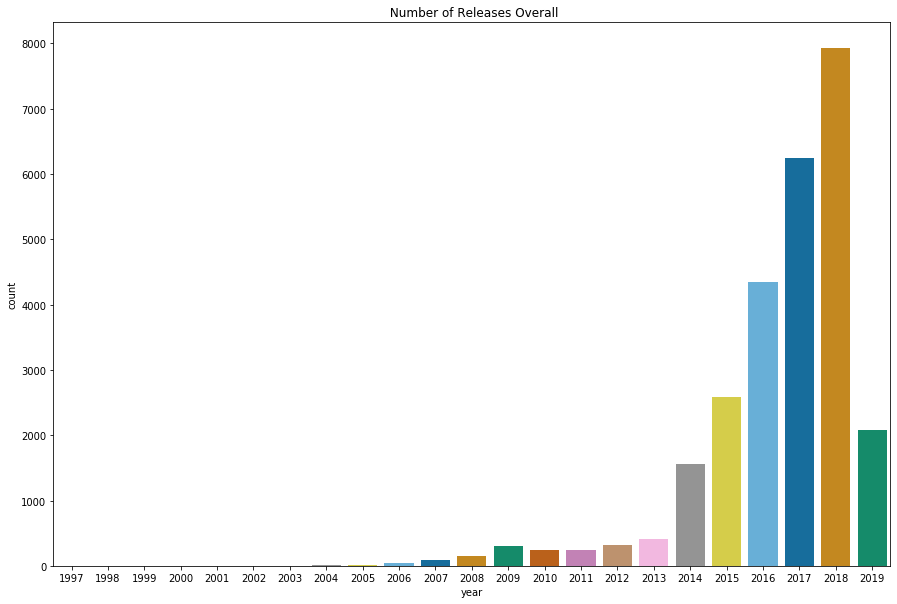

In [39]:
#setting plot figure size
plt.figure(figsize = (15,10))
#countplot of releases by year before 2008
ax = sns.countplot(x = 'year', data = cleaned_steam_data, palette = 'colorblind').set_title(' Number of Releases Overall')

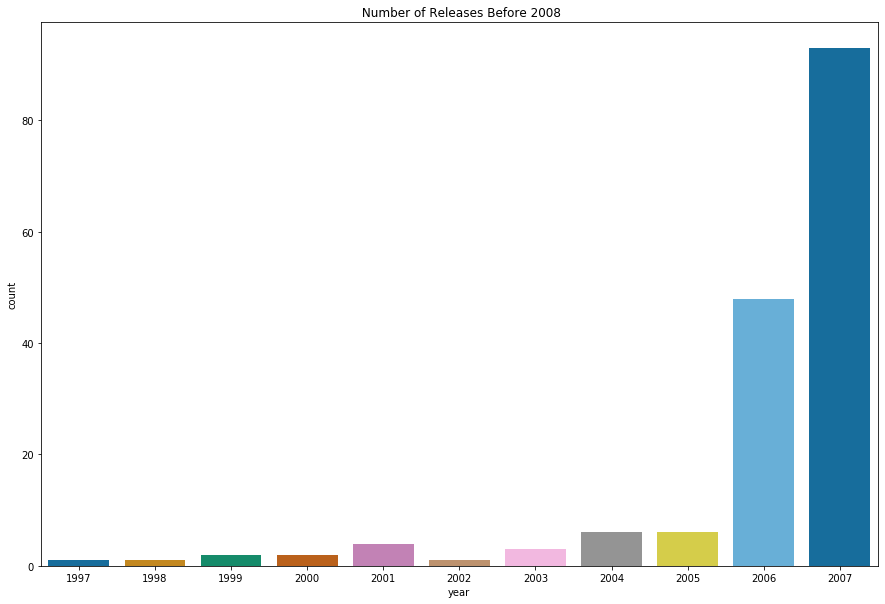

In [40]:
#splitting dataframe in half
before_2008 = cleaned_steam_data[cleaned_steam_data['year'] < 2008]
#setting plot figure size
plt.figure(figsize = (15,10))
#countplot of releases by year before 2008
ax = sns.countplot(x = 'year', data = before_2008, palette = 'colorblind').set_title(' Number of Releases Before 2008')

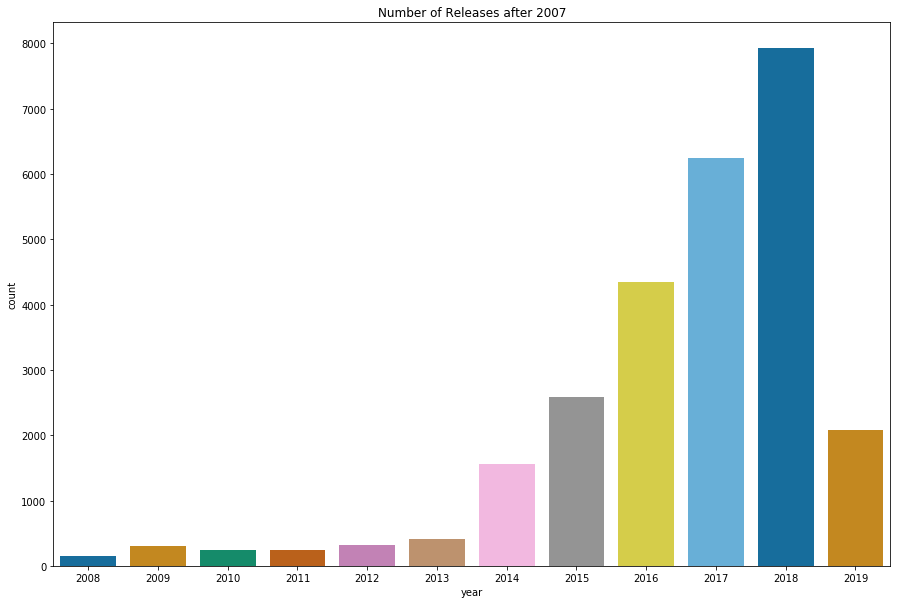

In [41]:
#splitting dataframe in half
after_2007 = cleaned_steam_data[cleaned_steam_data['year'] > 2007]
#setting plot figure size
plt.figure(figsize = (15,10))
#countplot of releases after 2007
ax = sns.countplot(x = 'year', data = after_2007, palette = 'colorblind').set_title('Number of Releases after 2007')

### Number of Releases by Month

- It looks like there is binomial distribution with the modes in March and October.
    - This is surprising to me because I thought that summer releases would be popular. However it looks like spring and fall releases are the popular season to release games.

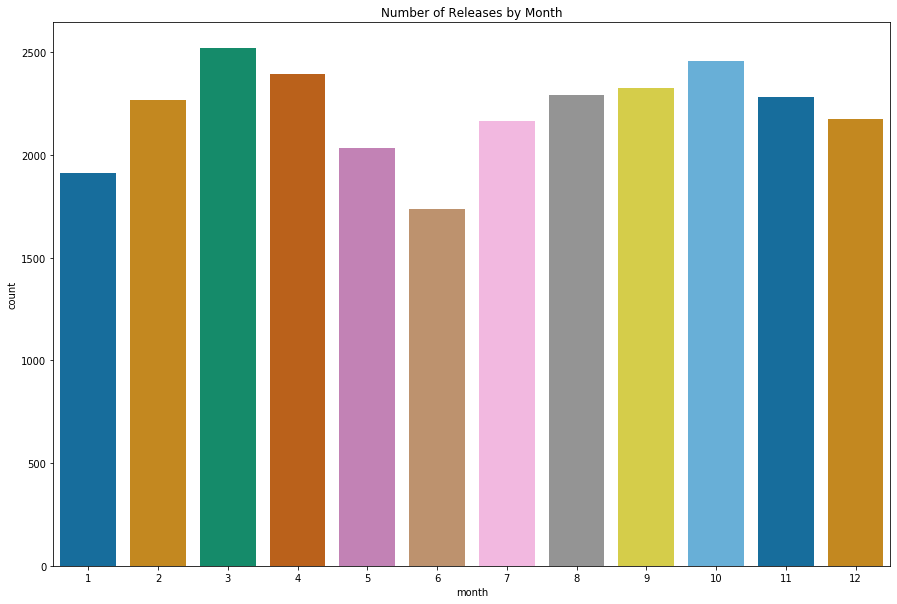

In [42]:
#setting plot figure size
plt.figure(figsize = (15,10))
#countplot of releases by month
ax = sns.countplot(x = 'month', data = cleaned_steam_data, palette = 'colorblind').set_title('Number of Releases by Month')

### Most Common Genre

- There are quite of bit of genres that are released on the Steam Platform that are not related to games.
- Indie is by far the most popular genre, most likely due to the ease in which developers can release their games onto the platform
    - One thing to note that Indie games is very vague genre cause it can encompass all the other genres as well
- Action, Casual, and Adventure are the next two common genres. This makes sense becaue it is a common genre.
- The numbers start to decrease as we get into more niche games like gore games, violent games, and MMOs

In [43]:
#saving all genres in a variable
genres = cleaned_steam_data.columns[-40:-11]

In [44]:
#sum of all genres
cleaned_steam_data[genres].sum()

Accounting                   5
Action                   11816
Adventure                 9798
Animation & Modeling        78
Audio Production            28
Casual                   10028
Design & Illustration       86
Documentary                  1
Early Access              2886
Education                   50
Free to Play              1645
Game Development            16
Gore                       530
Indie                    19092
Massively Multiplayer      698
Nudity                     257
Photo Editing               11
RPG                       4084
Racing                    1021
Sexual Content             238
Simulation                5084
Software Training           30
Sports                    1317
Strategy                  5103
Tutorial                     1
Utilities                  144
Video Production            37
Violent                    832
Web Publishing              27
dtype: int64

In [45]:
#saving all game genres in a variable
game_genres = ['Action', 
              'Adventure', 
              'Casual', 
              'Early Access', 
              'Free to Play', 
              'Gore', 
              'Indie', 
              'Massively Multiplayer', 
              'RPG', 
              'Racing', 
              'Simulation', 
              'Sports', 
              'Strategy', 
              'Violent']

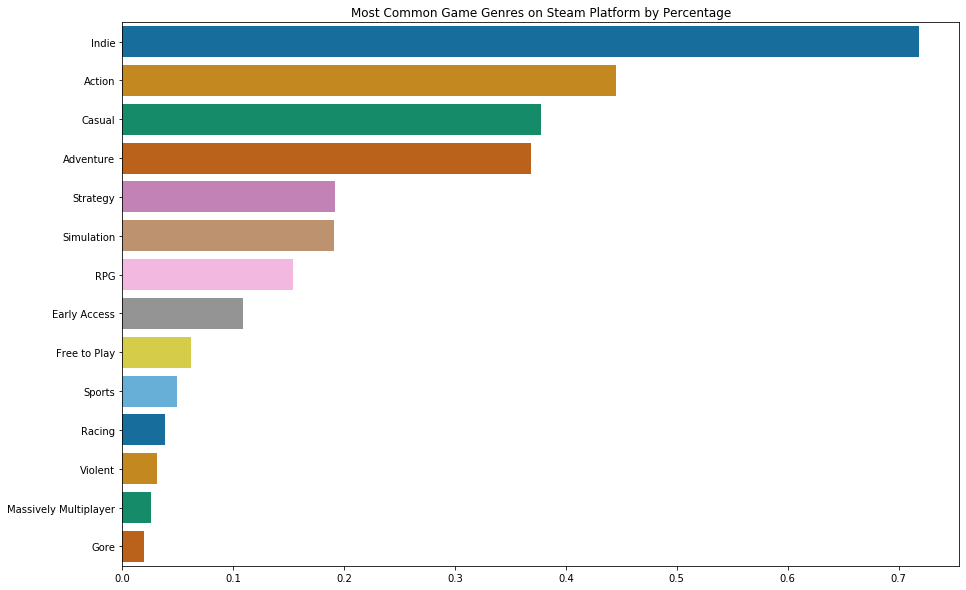

In [46]:
#setting plot figure size
plt.figure(figsize = (15,10))
#barplot of common game genres
ax = sns.barplot(data = cleaned_steam_data[game_genres], 
                 order = cleaned_steam_data[game_genres].sum().sort_values(ascending = False).index, 
                 orient = 'h',
                 palette = 'colorblind',
                 ci = None
                ).set_title('Most Common Game Genres on Steam Platform by Percentage')

### Number of Games Released by Developers

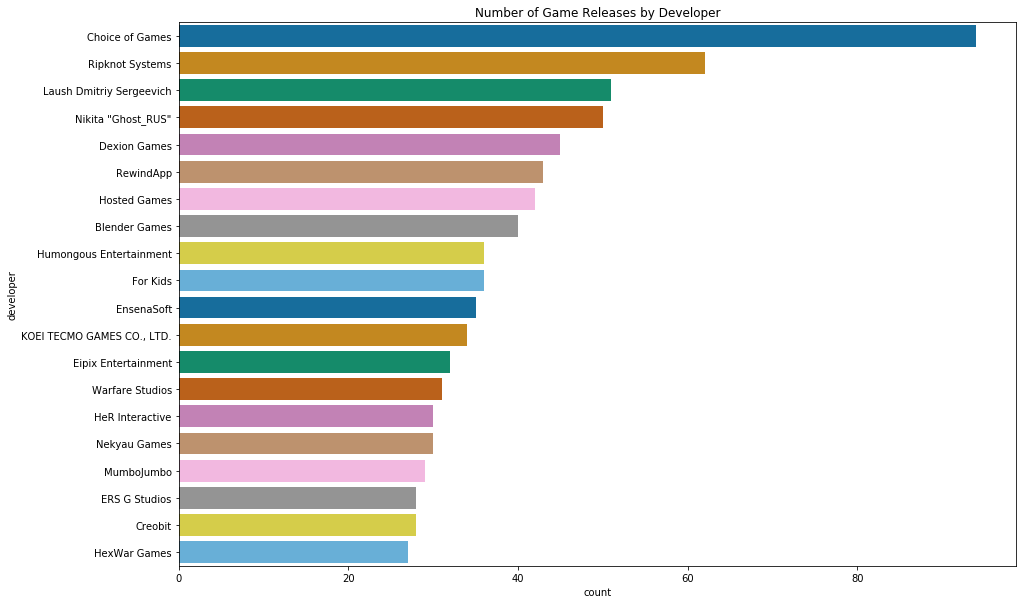

In [47]:
#setting plot figure size
plt.figure(figsize = (15, 10))
#countplot of releases by developers
ax = sns.countplot(y = 'developer', 
                   data = cleaned_steam_data, 
                   order = cleaned_steam_data['developer'].value_counts()[:20].index, 
                   palette = 'colorblind').set_title('Number of Game Releases by Developer')

### Top 20 Releases

In [48]:
#sorted dataframe by rating
cleaned_steam_data.sort_values('rating', ascending = False)[['name', 'genres', 'price', 'rating']].head(20)

,name,genres,price,rating
23,Portal 2,Action;Adventure,7.19,97.257760
7577,Factorio,Casual;Indie;Simulation;Strategy;Early Access,21.00,96.601391
2964,The Witcher® 3: Wild Hunt,RPG,24.99,96.465364
17,Portal,Action,7.19,96.103502
0,Counter-Strike,Action,7.19,95.975678
1120,Terraria,Action;Adventure;Indie;RPG,6.99,95.907030
1962,The Binding of Isaac: Rebirth,Action,10.99,95.871763
3036,RimWorld,Indie;Simulation;Strategy,27.79,95.802600
21,Left 4 Dead 2,Action,7.19,95.631142
1596,Euro Truck Simulator 2,Indie;Simulation,14.99,95.547966


### Prices by Rating

There seems to be slight positive relationship between the price of game and the rating it receives. However there is a lot of variance so the relationship is not very strong.

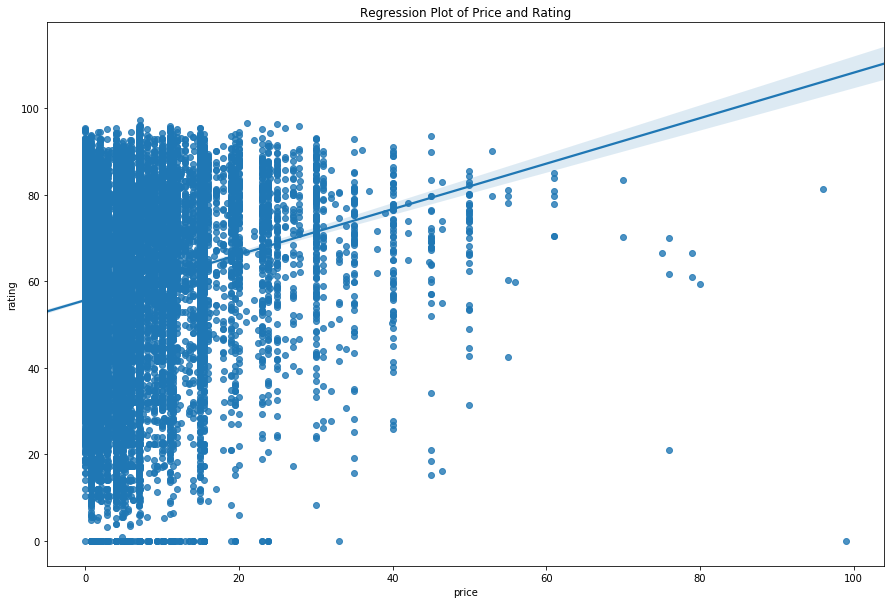

In [49]:
#setting plot figure size
plt.figure(figsize = (15, 10))

#box plot of ratings by owners
ax = sns.regplot(x = 'price', y = 'rating', data = cleaned_steam_data[cleaned_steam_data['price'] < 100]).set_title('Regression Plot of Price and Rating')

### Prices by Game Genres

- On first visualization. The box plots are heavily influenced by outliers. I will filter the data to get a better understanding of the prices.
- On second visualization. Now that the data is filtered (Still quite a bit of outliers) we have a better understanding of data.
    - Most of the prices for each genre seem to fall between 1 and 25 dollar range.

In [50]:
#new dataframe for pricing
price_by_genre_df = pd.DataFrame()

#concatinating prices of all gaming related genres
for col in game_genres:
    price = pd.DataFrame(cleaned_steam_data.loc[cleaned_steam_data[col] == 1, 'price'].values, columns=['price'])
    price['genre'] = col
    price_by_genre_df = pd.concat([price_by_genre_df, price], axis=0)

In [51]:
#top 5 results of price dataframe
price_by_genre_df.head()

,price,genre
0,7.19,Action
1,3.99,Action
2,3.99,Action
3,3.99,Action
4,3.99,Action


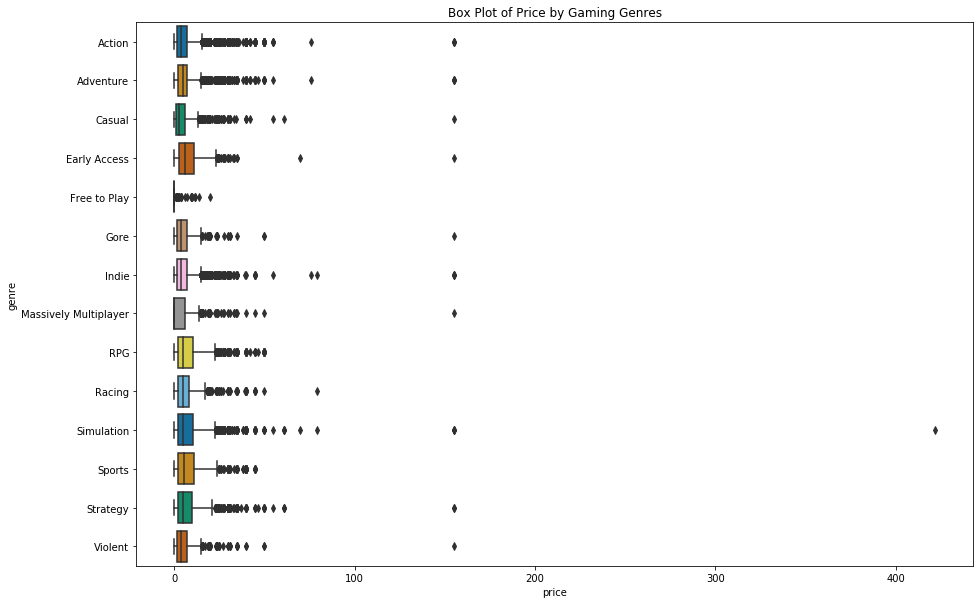

In [52]:
#setting plot figure size
plt.figure(figsize = (15, 10))
#box plot of price by genre
ax = sns.boxplot(x = 'price', y = 'genre', data = price_by_genre_df, palette = 'colorblind').set_title('Box Plot of Price by Gaming Genres')

In [53]:
#filtered the data
filtered_price_genre = price_by_genre_df[(price_by_genre_df['price'] < price_by_genre_df['price'].quantile(.995)) & (price_by_genre_df['price'] > price_by_genre_df['price'].quantile(.005))]

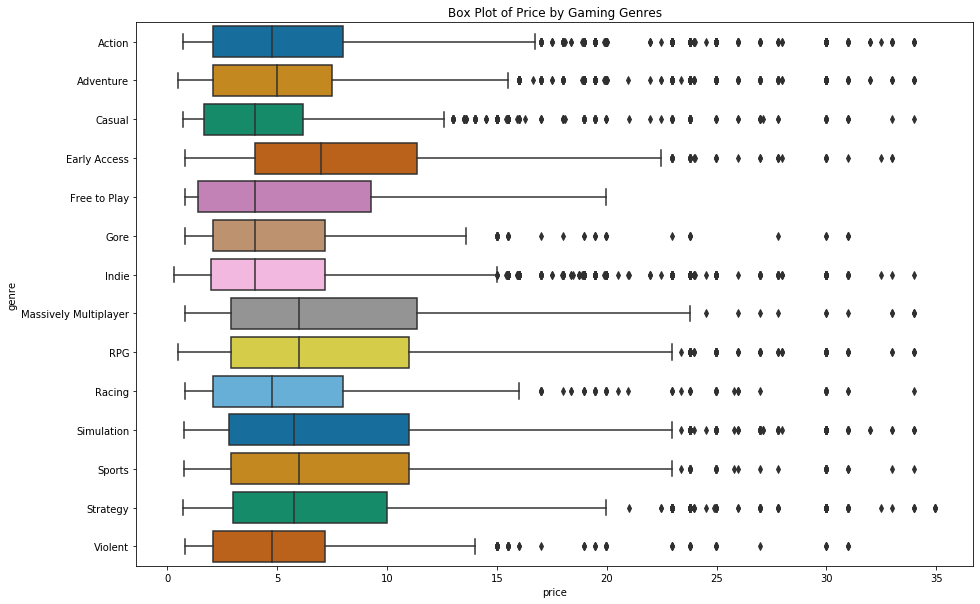

In [54]:
#setting plot figure size
plt.figure(figsize = (15, 10))
#box plot of price by genre
ax = sns.boxplot(x = 'price', y = 'genre', data = filtered_price_genre, palette = 'colorblind').set_title('Box Plot of Price by Gaming Genres')

### Price of Games by Number of Owners

- Similar to prices by genre. The prices are heavily influenced by the outliers so I will filter the data again.
- The prices by owners has a slight trend upwards as the number of owners increase but then goes back down after the 2 million mark.

In [55]:
#new dataframe for pricing by owner
price_by_owner_df = pd.DataFrame()

#concatinating prices of all gaming related genres
for col in number_of_owners:
    price = pd.DataFrame(cleaned_steam_data.loc[cleaned_steam_data[col] == 1, 'price'].values, columns=['price'])
    price['owners'] = col
    price_by_owner_df = pd.concat([price_by_owner_df, price], axis=0)

In [56]:
price_by_owner_df.head()

,price,owners
0,5.99,0-20k
1,3.99,0-20k
2,0.00,0-20k
3,6.99,0-20k
4,4.79,0-20k


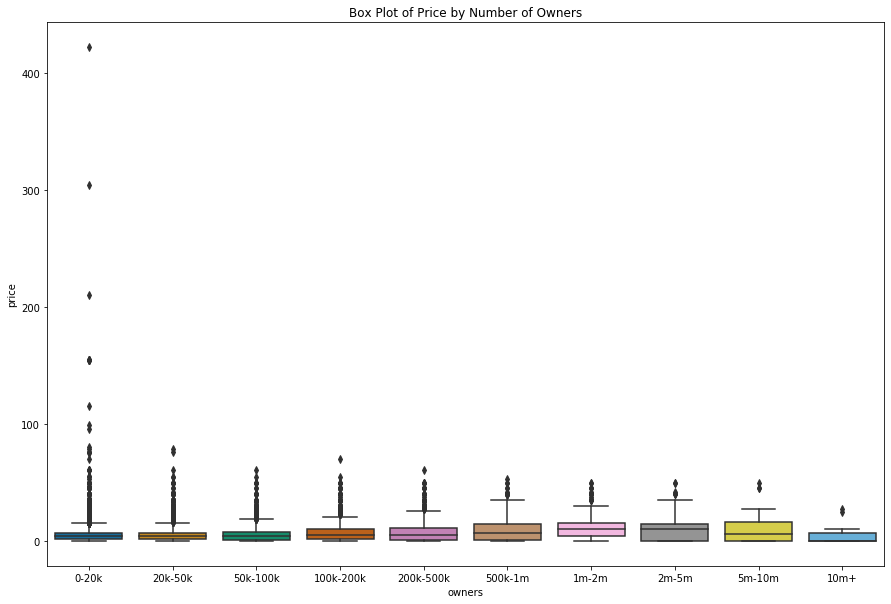

In [57]:
#setting plot figure size
plt.figure(figsize = (15, 10))
#box plot of price by genre
ax = sns.boxplot(y = 'price', x = 'owners', data = price_by_owner_df, palette = 'colorblind').set_title('Box Plot of Price by Number of Owners')

In [58]:
#normalizing the price column
filtered_price_owners = price_by_owner_df[(price_by_owner_df['price'] < price_by_owner_df['price'].quantile(.995)) & (price_by_owner_df['price'] > price_by_owner_df['price'].quantile(.005))]

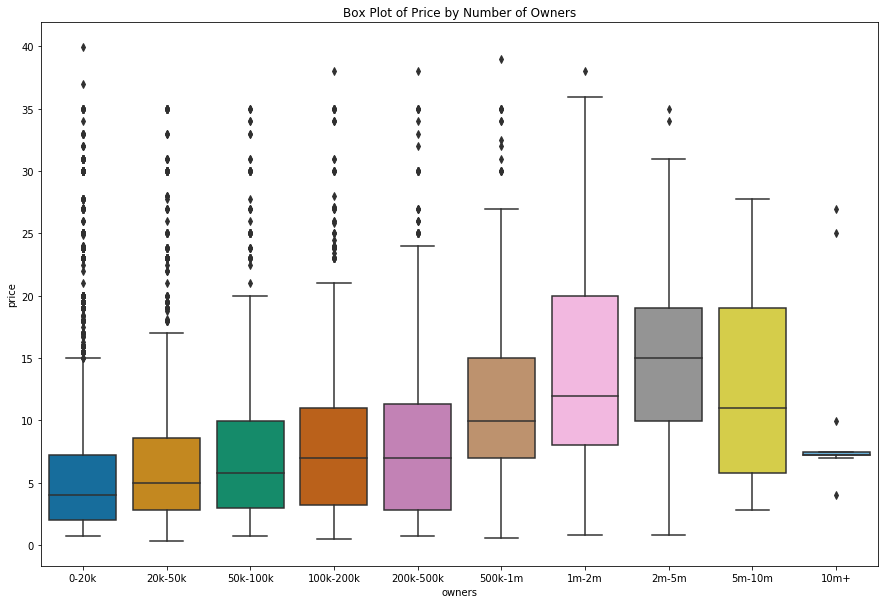

In [59]:
#setting plot figure size
plt.figure(figsize = (15, 10))
#box plot of price by number of owners
ax = sns.boxplot(y = 'price', x = 'owners', data = filtered_price_owners, palette = 'colorblind').set_title('Box Plot of Price by Number of Owners')

### Price of

### Ratings by Genre

- The ratings by Genre are all very similar to each other with most of the data falling betwee the 35 and 70 range.

In [60]:
#new dataframe for rating by genre
rating_by_genre_df = pd.DataFrame()

#concatinating rating of all gaming related genres
for col in game_genres:
    rating = pd.DataFrame(cleaned_steam_data.loc[cleaned_steam_data[col] == 1, 'rating'].values, columns=['rating'])
    rating['genre'] = col
    rating_by_genre_df = pd.concat([rating_by_genre_df, rating], axis=0)

In [61]:
#top 5 results of rating by genre dataframe
rating_by_genre_df.head()

,rating,genre
0,95.975678,Action
1,80.508259,Action
2,85.823915,Action
3,78.126542,Action
4,91.260480,Action


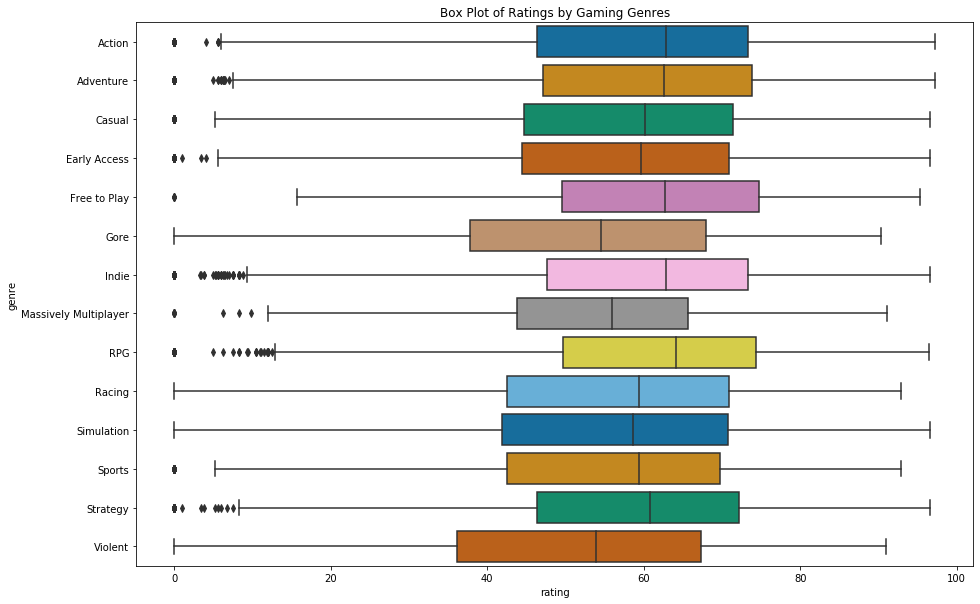

In [62]:
#setting plot figure size
plt.figure(figsize = (15, 10))
#box plot of ratings by genre
ax = sns.boxplot(x = 'rating', y = 'genre', data = rating_by_genre_df, palette = 'colorblind').set_title('Box Plot of Ratings by Gaming Genres')

### Ratings by Number of Owners

- As the number of owners increased, the ratings increase as well.
- The whishers of each box also have decreased which tells us that there is less variance in the data as the number of owners increase.

In [63]:
#new dataframe for rating by owner
rating_by_owner_df = pd.DataFrame()

#concatinating ratings by number of owners
for col in number_of_owners:
    rating = pd.DataFrame(cleaned_steam_data.loc[cleaned_steam_data[col] == 1, 'rating'].values, columns=['rating'])
    rating['owners'] = col
    rating_by_owner_df = pd.concat([rating_by_owner_df, rating], axis=0)

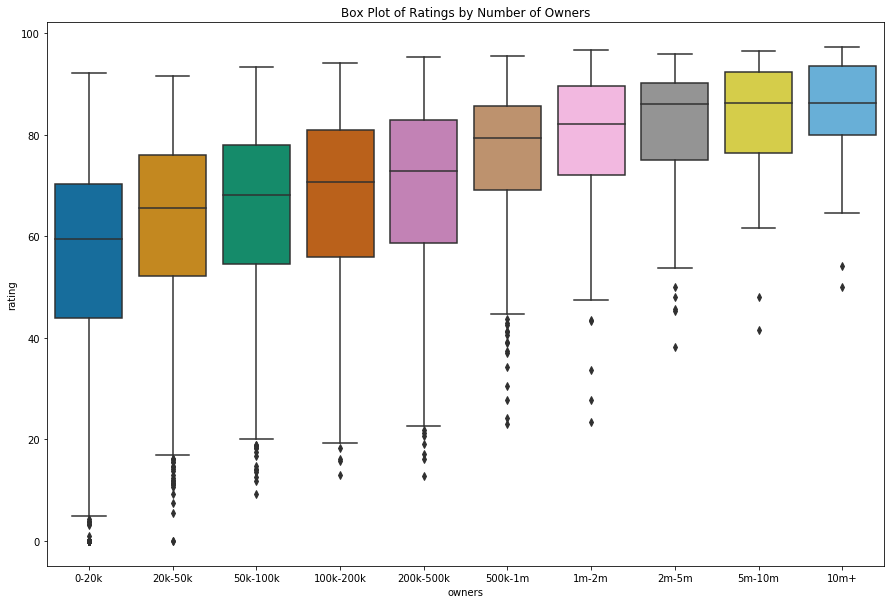

In [64]:
#setting plot figure size
plt.figure(figsize = (15, 10))

#box plot of ratings by owners
ax = sns.boxplot(y = 'rating', x = 'owners', data = rating_by_owner_df, palette = 'colorblind').set_title('Box Plot of Ratings by Number of Owners')

### Correlation Heatmap

Text(0.5, 1, 'Steam Data Correlation Heatmap')

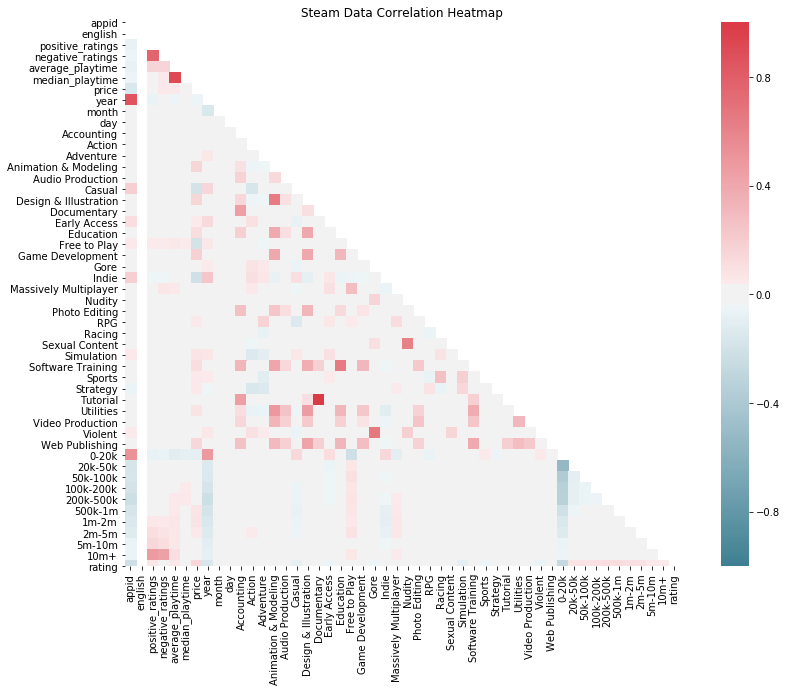

In [65]:
#variable of column names
columns = list(cleaned_steam_data)

#calculating correlation values
corr = cleaned_steam_data[columns].corr()

#setting plot figure size
plt.figure(figsize = (15, 10))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1,vmin = -1, center = 0, square=True).set_title('Steam Data Correlation Heatmap')

Text(0.5, 1, 'Game Genres and Owner Correlation')

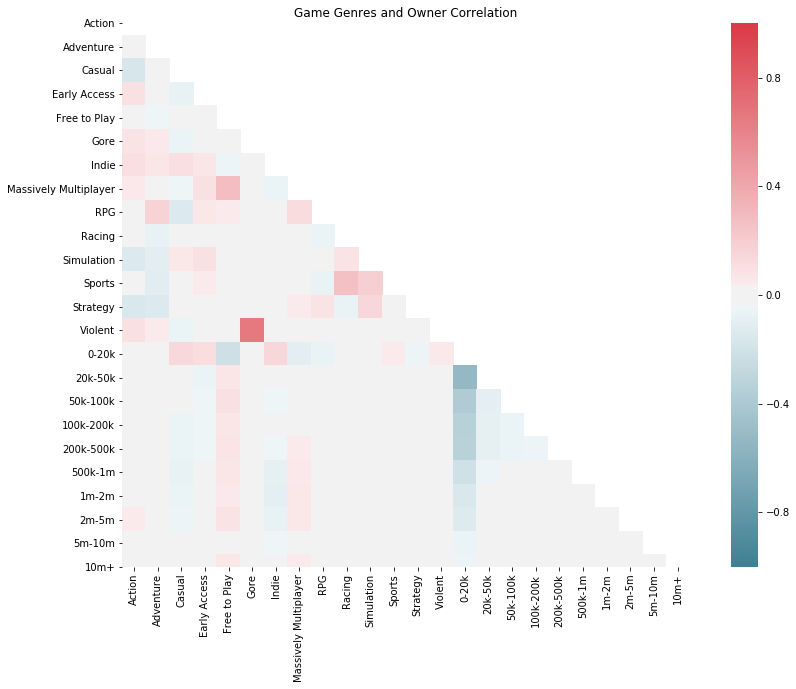

In [66]:
#calculating correlation values
corr = cleaned_steam_data[game_genres + number_of_owners].corr()

#setting plot figure size
plt.figure(figsize = (15, 10))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1,vmin = -1, center = 0, square=True).set_title('Game Genres and Owner Correlation')

Text(0.5, 1, 'Game Genres and Owner Correlation')

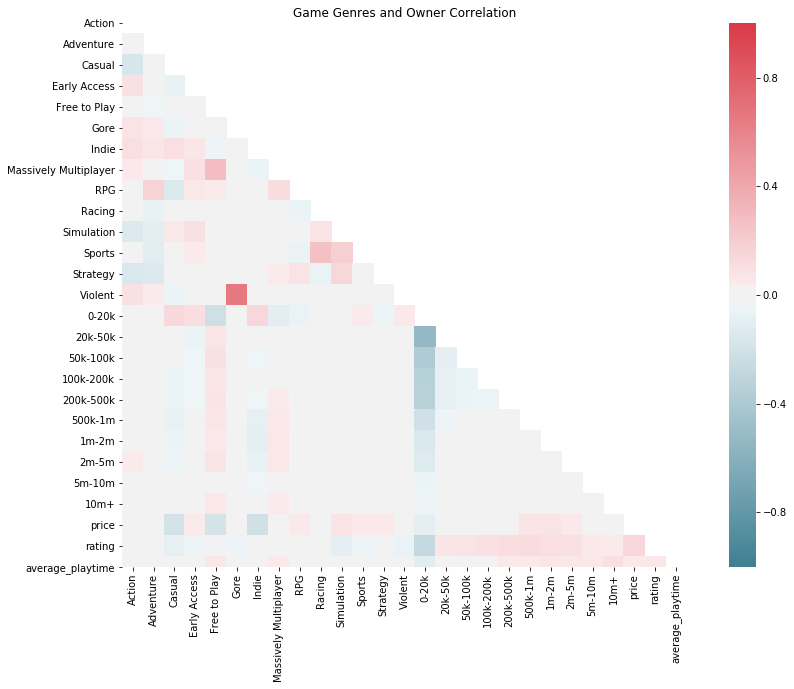

In [67]:
#list of additional columns to add to heatmap
add_columns = ['price', 'rating', 'average_playtime']

corr = cleaned_steam_data[game_genres + number_of_owners + add_columns].corr()

#setting plot figure size
plt.figure(figsize = (15, 10))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1,vmin = -1, center = 0, square=True).set_title('Game Genres and Owner Correlation')

## Conclusion

Here are some of the findings that was found so far. I would like to explore the data in future as there is still more to dive deeper into, but this will it for now.

- The number of releases have increases significantly since 2014.
- Spring and Fall seasons are more popular for releases as opposed to Summer and Fall.
- Broad genres such as Indie, Action, Casual, and Adventure are more common than niche games like violent, gore, and MMOs
- Most of the prices of game related genres fall between the 2.50 and 25 dollar range
- The prices by owners has a slight trend upwards as the number of owners increase but then goes back down after the 2 million mark.
- The is postive relationship between the price and rating of game. As the price increase, the higher chance that it will receive a higher rating. There is a lot of variance so the relationship is not very strong.
- The higher number of owners will increase the likelihood of receiving a higher rating.

